In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from shapely.geometry import LineString, Point
from keplergl import KeplerGl

In [2]:
column_names = ['id', 'name', 'city', 'country', 'IATA', 'ICAO', 
                'Latitude', 'Longtitude', 'Altitude', 'Timezone', 'DST', 'Tz_database_time', 'Type', 'Source']

dataframe = pd.read_csv('airports.csv', names=column_names)
dataframe.head()

,id,name,city,country,IATA,ICAO,Latitude,Longtitude,Altitude,Timezone,DST,Tz_database_time,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [3]:
dataframe = dataframe.drop(columns=['id', 'DST', 'Timezone', 'Tz_database_time', 'Type', 'Source'])
dataframe.head()

,name,city,country,IATA,ICAO,Latitude,Longtitude,Altitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


In [4]:
dataframe = dataframe.replace(to_replace=r'\N', value=np.NaN)
dataframe.tail(10)

,name,city,country,IATA,ICAO,Latitude,Longtitude,Altitude
7688,Rustaq Airport,Al Masna'ah,Oman,MNH,OORQ,23.640556,57.487500,349
7689,Laguindingan Airport,Cagayan de Oro City,Philippines,CGY,RPMY,8.612203,124.456496,190
7690,Kostomuksha Airport,Kostomuksha,Russia,NaN,ULPM,64.617996,30.687000,681
7691,Privolzhskiy Air Base,Astrakhan,Russia,NaN,XRAP,46.396000,47.893000,-66
7692,Kubinka Air Base,Kubinka,Russia,NaN,UUMB,55.611695,36.650002,614
7693,Rogachyovo Air Base,Belaya,Russia,NaN,ULDA,71.616699,52.478298,272
7694,Ulan-Ude East Airport,Ulan Ude,Russia,NaN,XIUW,51.849998,107.737999,1670
7695,Krechevitsy Air Base,Novgorod,Russia,NaN,ULLK,58.625000,31.385000,85
7696,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670
7697,Melitopol Air Base,Melitopol,Ukraine,NaN,UKDM,46.880001,35.305000,0


In [5]:
dataframe = dataframe.dropna()
dataframe.isnull().sum()

name          0
city          0
country       0
IATA          0
ICAO          0
Latitude      0
Longtitude    0
Altitude      0
dtype: int64

(-197.86839904745, 197.94240417445, -69.426229667625, 89.75322933192501)

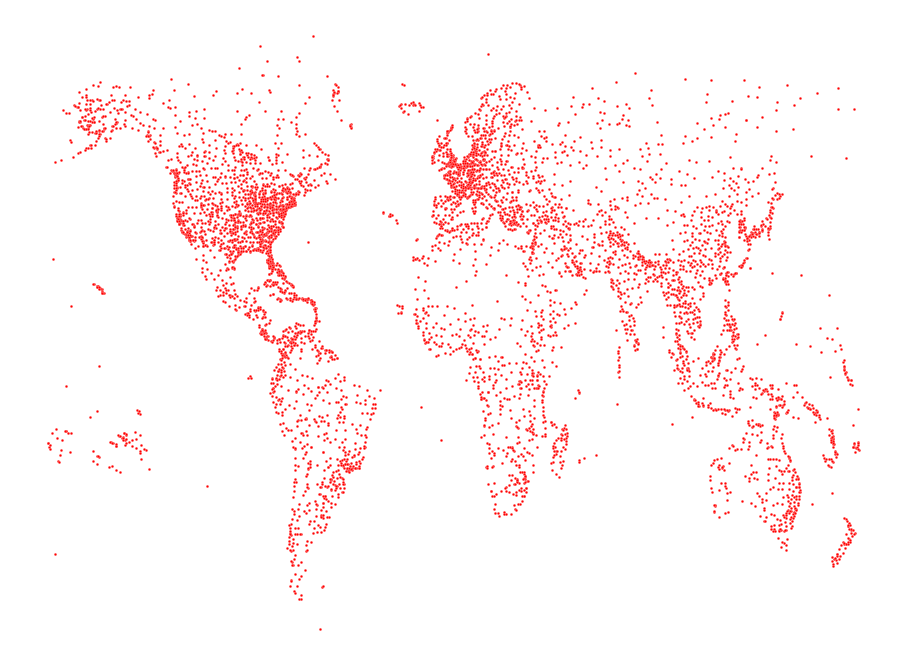

In [6]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
sns.scatterplot(x='Longtitude', y='Latitude', data=dataframe, ax=ax, color='red', s=7, markers='+')
ax.axis('off')

In [7]:
column_names = ['Airline', 'Airline_id', 'source_airport', 'source_airport_id', 
               'destination_airport', 'destination_airport_id', 'codeshare', 'stops', 'equipment']

dataframe_route = pd.read_csv('routes.csv', names=column_names)
dataframe_route = dataframe_route.drop(columns=['codeshare', 'stops'])
dataframe_route = dataframe_route.dropna()
dataframe_route.head()

,Airline,Airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,equipment
0,2B,410,AER,2965,KZN,2990,CR2
1,2B,410,ASF,2966,KZN,2990,CR2
2,2B,410,ASF,2966,MRV,2962,CR2
3,2B,410,CEK,2968,KZN,2990,CR2
4,2B,410,CEK,2968,OVB,4078,CR2


In [8]:
source = dataframe[['name', 'IATA', 'ICAO', 'Latitude', 'Longtitude', 'Altitude']]
destination = dataframe[['name', 'IATA', 'ICAO', 'Latitude', 'Longtitude', 'Altitude']]

source.columns = [str(column) + '_source' for column in source.columns]
destination.columns = [str(column) + '_destination' for column in destination.columns]

In [9]:
dataframe_routes_wp = dataframe_route[['source_airport', 'destination_airport']]
dataframe_routes_wp = pd.merge(dataframe_routes_wp, source, left_on='source_airport', right_on='IATA_source')
dataframe_routes_wp = pd.merge(dataframe_routes_wp, destination, left_on='destination_airport', right_on='IATA_destination')

In [10]:
dataframe_routes_wp.head()

,source_airport,destination_airport,name_source,IATA_source,ICAO_source,Latitude_source,Longtitude_source,Altitude_source,name_destination,IATA_destination,ICAO_destination,Latitude_destination,Longtitude_destination,Altitude_destination
0,AER,KZN,Sochi International Airport,AER,URSS,43.449902,39.956600,89,Kazan International Airport,KZN,UWKD,55.606201,49.278702,411
1,ASF,KZN,Astrakhan Airport,ASF,URWA,46.283298,48.006302,-65,Kazan International Airport,KZN,UWKD,55.606201,49.278702,411
2,CEK,KZN,Chelyabinsk Balandino Airport,CEK,USCC,55.305801,61.503300,769,Kazan International Airport,KZN,UWKD,55.606201,49.278702,411
3,DME,KZN,Domodedovo International Airport,DME,UUDD,55.408798,37.906300,588,Kazan International Airport,KZN,UWKD,55.606201,49.278702,411
4,DME,KZN,Domodedovo International Airport,DME,UUDD,55.408798,37.906300,588,Kazan International Airport,KZN,UWKD,55.606201,49.278702,411


In [11]:
geometry_line, geometry_point = [], []

for i in tqdm(range(dataframe_routes_wp.shape[0])):
    line = LineString([
                       [dataframe_routes_wp.iloc[i]['Longtitude_source'], dataframe_routes_wp.iloc[i]['Latitude_source']], 
                       [dataframe_routes_wp.iloc[i]['Longtitude_destination'], dataframe_routes_wp.iloc[i]['Latitude_destination']]
    ])
    geometry_line.append(line)
    
for i in tqdm(range(dataframe.shape[0])):
    point = Point(dataframe.iloc[i]['Longtitude'], dataframe.iloc[i]['Latitude'])
    geometry_point.append(point)

100%|██████████| 6033/6033 [00:01<00:00, 3813.62it/s]


In [12]:
geo_dataframe_airports = gpd.GeoDataFrame(dataframe, geometry=geometry_point)
geo_dataframe_routes_wp = gpd.GeoDataFrame(dataframe_routes_wp, geometry=geometry_line)

In [13]:
from math import sin, cos, atan2, sqrt, radians, pi

def HaversineFormula(s_lat, s_long, t_lat, t_long):
    radius_of_earth = 6371
    
    d_lon_in_rad = radians(t_long - s_long)
    d_lat_in_rad = radians(t_lat - s_lat)
    s_lat_in_rad = radians(s_lat) 
    t_lat_in_rad = radians(t_lat)
    
    a = sin(d_lat_in_rad / 2) ** 2 + cos(s_lat_in_rad) * cos(t_lat_in_rad) * sin(d_lon_in_rad / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = radius_of_earth * c
    
    return distance

In [14]:
#This is not very efficient way to assign distance variables. 
#But it's not stupid if it works :DDD (PS: will find a way to do it properly ^_^)

geo_dataframe_routes_wp['distance_km'] = 0

for i in tqdm(range(geo_dataframe_routes_wp.shape[0])):
    s_lat = geo_dataframe_routes_wp.iloc[i]['Latitude_source']
    s_long = geo_dataframe_routes_wp.iloc[i]['Longtitude_source']
    t_lat = geo_dataframe_routes_wp.iloc[i]['Latitude_destination']
    t_long = geo_dataframe_routes_wp.iloc[i]['Longtitude_destination']
    
    geo_dataframe_routes_wp.iloc[[i], [15]] = HaversineFormula(s_lat, s_long, t_lat, t_long)

100%|██████████| 66912/66912 [00:38<00:00, 1741.38it/s]


In [ ]:
keplerGL = KeplerGl()
keplerGL.add_data(geo_dataframe_routes_wp, 'Flight paths')
keplerGL.add_data(geo_dataframe_airports, 'Airports')
keplerGL.save_to_html()